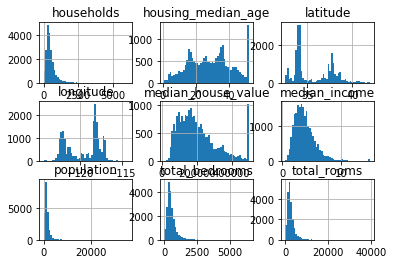

In [1]:
import fetchData
#fetchData.fetch_housing_data()
house = fetchData.load_housing_data()
#house.head()
#house.info()
#house["ocean_proximity"].value_counts()
#house.describe()
%matplotlib inline
import matplotlib.pyplot as plt
house.hist(bins=50)
plt.show()

In [2]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
# get income into buckets .. if too much income, put all above 5 into 5 bucket
house["income_cat"] = np.ceil(house["median_income"] / 1.5)
house["income_cat"].where(house["income_cat"] < 5, 5.0, inplace=True)
# this will split train/test set with same population by concerning income_cat derived above
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(house, house["income_cat"]):
    strat_train_set = house.loc[train_index]
    strat_test_set = house.loc[test_index]
#house["income_cat"].value_counts()
# we can then remove the income_cat as it's used for spliting data only
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)
    
#simple data prep
#from sklearn.model_selection import train_test_split
#train_set, test_set = train_test_split(house, test_size=0.2, random_state=42)


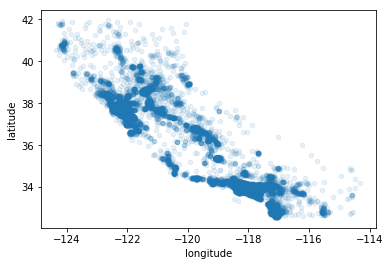

In [3]:
# now .. lets get train data
house = strat_train_set.copy()
house.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) #alpha help illustrate the density

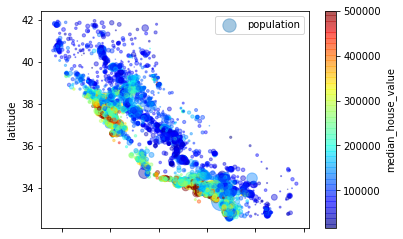

In [4]:
# plot house price with cmap (blue low -> red high)
# plot population with radius
# s = radius
# c = color
house.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
          s=house["population"]/100, label="population",
          c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

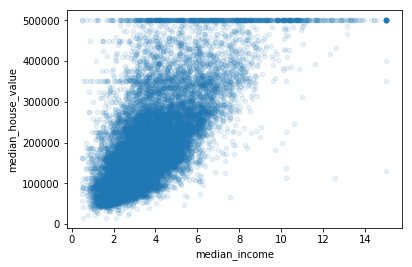

In [5]:
# find correlation of each feature
corr_matrix = house.corr()
#corr_matrix["median_house_value"].sort_values(ascending=False)

# because median_income is most correlate to house_value .. let's plot the graph btween these two
house.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [6]:
# copy a fresh one and separate the label
house = strat_train_set.copy()
house = house.drop("median_house_value", axis=1)
house_label = strat_train_set["median_house_value"].copy()


# find median and fill na (not available)
median = house["total_bedrooms"].median()
house["total_bedrooms"].fillna(median)

# transform proximity to number
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
house_cat = house["ocean_proximity"]
house_cat_1hot = encoder.fit_transform(house_cat)
house_cat_1hot

# drop proximity
house_num = house.drop("ocean_proximity", axis=1)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler #normalize with standardization
from sklearn.preprocessing import Imputer # fillna with median

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])
house_num_tr = num_pipeline.fit_transform(house_num)


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler #normalize with standardization
from sklearn.preprocessing import Imputer # fillna with median
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer # encode text

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values
    
num_attribs = list(house_num)
cat_attribs = ["ocean_proximity"]
    
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])
house_num_tr = num_pipeline.fit_transform(house)
#house_num_td = cat_pipeline.fit_transform(house)

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    #("cat_pipeline", cat_pipeline)
])
#num_attribs

house_prepared = full_pipeline.fit_transform(house)
house_prepared

# preprocessing done here ..
# things are ready

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

In [9]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score # cross validation

lin_reg = LinearRegression()
lin_reg.fit(house_prepared, house_label)

# test
some_data = house.iloc[:5]
some_labels = house_label.iloc[:5]
some_data_prepare = full_pipeline.transform(some_data)
print("prediction:\t",lin_reg.predict(some_data_prepare))
print("labels:\t",list(some_labels))

# find error rate of training set ..
from sklearn.metrics import mean_squared_error
house_predictions = lin_reg.predict(house_prepared)
line_mse = mean_squared_error(house_label, house_predictions)
line_rmse = np.sqrt(line_mse)
line_rmse

# cross validation
scores = cross_val_score(lin_reg, house_prepared, house_label, scoring="neg_mean_squared_error", cv=10) #10 folds
rmse_scores = np.sqrt(-scores)
print("scores:", rmse_scores)
print("mean:", rmse_scores.mean())
print("std:", rmse_scores.std())

prediction:	 [ 207533.05517343  322908.00664981  205636.93169928   75429.96006053
  188528.17569525]
labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
scores: [ 68231.8739688   68498.24540696  69602.95540263  74953.53757784
  68963.39008985  72142.21999409  66587.92731065  69747.54809465
  73515.43621253  68938.5043212 ]
mean: 70118.1638379
std: 2465.59915624


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [10]:
# decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score # cross validation

tree_reg = DecisionTreeRegressor()
tree_reg.fit(house_prepared, house_label)

# test
house_predictions = tree_reg.predict(house_prepared)
tree_mse = mean_squared_error(house_label, house_predictions)
line_rmse = np.sqrt(tree_mse)
line_rmse

# cross validation
scores = cross_val_score(tree_reg, house_prepared, house_label, scoring="neg_mean_squared_error", cv=10) #10 folds
rmse_scores = np.sqrt(-scores)
print("scores:", rmse_scores)
print("mean:", rmse_scores.mean())
print("std:", rmse_scores.std())

scores: [ 68012.83106251  68953.81404849  71980.16256379  68397.65117171
  68735.06481314  73522.12281589  70482.64397304  69582.92362008
  70622.11679455  70797.2456316 ]
mean: 70108.6576495
std: 1638.55985858


In [11]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(house_prepared, house_label)

# cross validation
scores = cross_val_score(forest_reg, house_prepared, house_label, scoring="neg_mean_squared_error", cv=10) #10 folds
rmse_scores = np.sqrt(-scores)
print("scores:", rmse_scores)
print("mean:", rmse_scores.mean())
print("std:", rmse_scores.std())

scores: [ 52275.72180839  49892.25321604  52065.07571073  53905.77927565
  51696.3653644   55575.90164375  50183.96722975  52390.07798037
  54305.87450109  51625.6466372 ]
mean: 52391.6663367
std: 1685.4501888


In [12]:
# test against test set
final_model = forest_reg

X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
mse = mean_squared_error(Y_test, final_predictions)
rmse = np.sqrt(mse)
rmse

49714.355077976994